
In this notebook, You will do amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.  Detailed instrctions are given in the each cell. please read every comment we have written. 
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. 
    If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List if we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>
</pre>

In [ ]:
#in this assignment you need two files reviews.csv and tokenization file
#you can use gdown module to import both the files in colab from Google drive
#the syntax is for gdown is !gdown --id file_id
#please run the below cell to import the required files


In [1]:
# !gdown --id 1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
# !gdown --id 13exfXiyiByluh1PfYK1EyZyizqxeCVG9

Downloading...
From: https://drive.google.com/uc?id=1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
To: /content/Reviews.csv
100% 301M/301M [00:02<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=13exfXiyiByluh1PfYK1EyZyizqxeCVG9
To: /content/tokenization.py
100% 17.3k/17.3k [00:00<00:00, 29.5MB/s]


In [1]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from tensorflow.keras.models import Model

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [18]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [87]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [88]:
#get only 2 columns - Text, Score
#drop the NAN values

reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator',
                     'HelpfulnessDenominator','Time','Summary'],axis=1)
reviews.dropna(subset = ["Text"], inplace=True)

reviews.head(5)

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


<h4>PREPROCESSING</h4>

In [89]:

#if score == 3, remove the rows. 
reviews = reviews.loc[ (reviews['Score']<=2) | (reviews['Score']>3) ]

#if score<=2, set score = 0
reviews['Score'] = reviews['Score'].replace([1,2], 0)

#if score> 3, set score = 1
reviews['Score'] = reviews['Score'].replace([4,5], 1)

reviews.head(5)

,Score,Text
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...


<font size=4>Grader function 2 </font>

In [90]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [91]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [92]:
#remove HTML from the Text column and save in the Text column only

reviews['Text'] = reviews['Text'].str.replace(r'<[^<>]*>', '', regex=True)


In [93]:
#print head 5

reviews.head(5)

,Score,Text,len
64117,1,The tea was of great quality and it tasted lik...,30
418112,1,My cat loves this. The pellets are nice and s...,31
357829,1,Great product. Does not completely get rid of ...,41
175872,1,This gum is my favorite! I would advise every...,27
178716,1,I also found out about this product because of...,22


In [94]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 

from sklearn.model_selection import train_test_split

X = reviews.drop(['Score','len'],axis=1)
Y = reviews['Score'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=23)

print(X_train.shape)
print(X_test.shape)

(80000, 1)
(20000, 1)


In [95]:
## reset index values

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

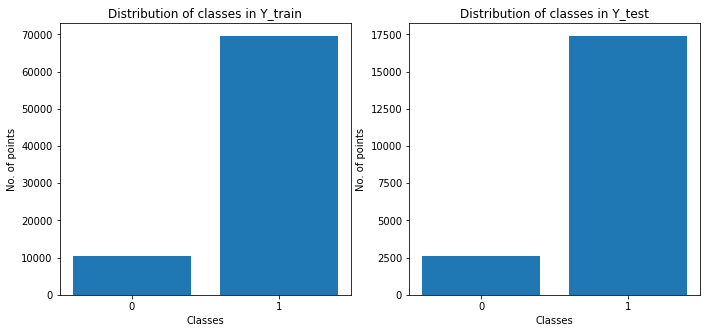

In [96]:
#plot bar graphs of y_train and y_test

y_tr = list(np.unique(Y_train,return_counts=True)[1])  ## no. of train datapoints with class label 1 and 0
y_ts = list(np.unique(Y_test,return_counts=True)[1])   ## no. of test datapoints with class label 1 and 0

fig = plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.bar(['0','1'],y_tr)
plt.title('Distribution of classes in Y_train')
plt.xlabel('Classes')
plt.ylabel('No. of points')

plt.subplot(1,2,2,)
plt.subplots_adjust(left=0.01)
plt.bar(['0','1'],y_ts)
plt.title('Distribution of classes in Y_test')
plt.xlabel('Classes')
plt.ylabel('No. of points')

plt.show()

From the 2 bar graph we can see that the dataset is imbalanced

In [29]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

In [139]:
reviews = pd.read_csv('preprocessed.csv')
reviews.head(5)

,Score,Text,len
0,1,The tea was of great quality and it tasted lik...,30
1,1,My cat loves this. The pellets are nice and s...,31
2,1,Great product. Does not completely get rid of ...,41
3,1,This gum is my favorite! I would advise every...,27
4,1,I also found out about this product because of...,22


<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [3]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [4]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 55)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

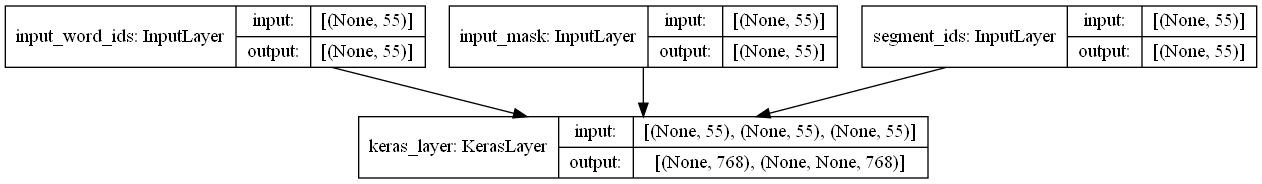

In [97]:
dot_img_file = 'image/bert.png'
plot_model(bert_model, to_file=dot_img_file, show_shapes=True)

In [5]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [6]:
#getting Vocab file

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [140]:
import tokenization  #We have given tokenization.py file

tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

<font size=4>Grader function 3 </font>

In [40]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

In [112]:
### FUNCTION FOR CREATING INPUTS TO BERT MODEL ###

def Bert_inputs(input_data,tokenizer):

    input_data_tokens  = []
    input_data_mask    = []
    input_data_segment = []

    for reviews in input_data.Text:
  
        tokens = tokenizer.tokenize(reviews)                     # split words in review
        if len(tokens) >= 54:                                    # if length of sentence is greater than 54, truncate
            tokens = tokens[:53]
        tokens = ['[CLS]',*tokens,'[SEP]']                       # add ['CLS'] to start and ['SEP'] to the end
        
        if len(tokens)<55:                                       # if length of sentence is less than 55           
            while len(tokens) < 55:                              # add the word ['PAD'] in remaining places
                tokens.append('[PAD]')                                            
        
        masked=[]
        for i in tokens:
            if i!='[PAD]':                                       # fill mask_array with 0 in place of ['PAD'] and 1 otherwise
                masked.append(1)
            else:
                masked.append(0)
        input_data_mask.append(masked)
    
        tokens = tokenizer.convert_tokens_to_ids(tokens)         # adding positional encoding to words
        input_data_tokens.append(tokens)    
    
        segment = [0]*55                                         # since inputting only 1 sentence giving segments as all zeroes
        input_data_segment.append(segment)

    input_data_tokens  =  np.array(input_data_tokens)
    input_data_mask    =  np.array(input_data_mask)
    input_data_segment =  np.array(input_data_segment)

    return input_data_tokens,input_data_mask,input_data_segment



In [113]:

X_train_tokens,X_train_mask,X_train_segment = Bert_inputs(X_train,tokenizer)  ## Train_data inputs for BERT

X_test_tokens,X_test_mask,X_test_segment    = Bert_inputs(X_test,tokenizer)   ## Test_data inputs for BERT


#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [13]:
import pickle

In [308]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, Y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, Y_test),open('test_data.pkl','wb'))

In [14]:
#you can load from disk
X_train, X_train_tokens, X_train_mask, X_train_segment, Y_train = pickle.load(open("train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, Y_test = pickle.load(open("test_data.pkl", 'rb')) 

<font size=4>Grader function 4 </font>

In [44]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [45]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [309]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [310]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [313]:
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [315]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [15]:
X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [318]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(Y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(Y_test)==len(X_test_pooled_output))
    assert(len(Y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(Y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric. Do not use tf.keras.metrics.AUC</b> 
<b> You have to write custom code for AUC and print it at the end of each epoch</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [45]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM, BatchNormalization, Embedding, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [69]:
## create an Neural Network and train your model on X_train_pooled_output and y_train


input_layer=Input(shape=(X_train_pooled_output.shape[1],))

dense_1 = Dense(256,activation='leaky_relu',kernel_initializer = 'he_normal',kernel_regularizer=l2(0.01))(input_layer)
dense_2 = Dense(128,activation='leaky_relu',kernel_initializer = 'he_normal',kernel_regularizer=l2(0.01))(dense_1)
dense_3 = Dense(64,activation='leaky_relu',kernel_initializer = 'he_normal',kernel_regularizer=l2(0.01))(dense_2)
dense_4 = Dense(32,activation='leaky_relu',kernel_initializer = 'he_normal',kernel_regularizer=l2(0.01))(dense_3)

output = Dense(2,activation='softmax')(dense_4)

model = Model(inputs=input_layer,outputs=output)
model.summary()


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 768)]             0         
_________________________________________________________________
dense_45 (Dense)             (None, 256)               196864    
_________________________________________________________________
dense_46 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_47 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_48 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 66        
Total params: 240,162
Trainable params: 240,162
Non-trainable params: 0
____________________________________________________

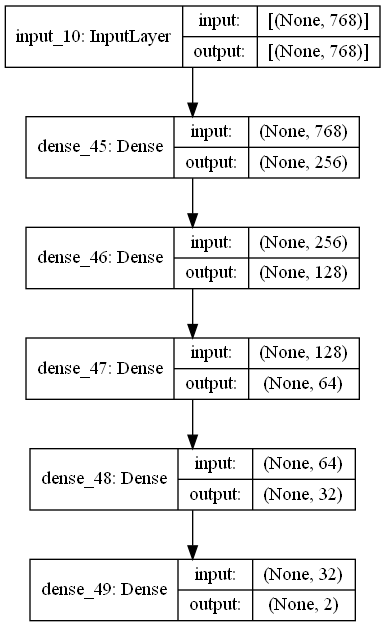

In [70]:
from tensorflow.keras.utils import plot_model
dot_img_file = 'image/model_1.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)

In [73]:
import tensorflow 
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
import datetime 
from tensorflow.keras.utils import to_categorical

## TENSORBOARD callback
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

## AUC score 
def aucroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

Y_train_ohe = to_categorical(Y_train)  ## converting y_train and y_test to one hot encoded values
Y_test_ohe = to_categorical(Y_test)

optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,loss='categorical_crossentropy' ,metrics=['accuracy',aucroc])

model.fit(X_train_pooled_output,Y_train_ohe,epochs=12,batch_size=128,
          validation_data=(X_test_pooled_output,Y_test_ohe),callbacks = [tensorboard_callback] )

Epoch 1/12
625/625 [==============================] - 6s 9ms/step - loss: 1.7982 - accuracy: 0.8746 - aucroc: 0.8358 - val_loss: 0.4172 - val_accuracy: 0.8824 - val_aucroc: 0.9151
Epoch 2/12
625/625 [==============================] - 5s 9ms/step - loss: 0.3465 - accuracy: 0.9021 - aucroc: 0.9313 - val_loss: 0.2927 - val_accuracy: 0.9183 - val_aucroc: 0.9394
Epoch 3/12
625/625 [==============================] - 5s 8ms/step - loss: 0.2970 - accuracy: 0.9088 - aucroc: 0.9407 - val_loss: 0.2699 - val_accuracy: 0.9208 - val_aucroc: 0.9418
Epoch 4/12
625/625 [==============================] - 5s 9ms/step - loss: 0.2855 - accuracy: 0.9115 - aucroc: 0.9430 - val_loss: 0.2925 - val_accuracy: 0.9166 - val_aucroc: 0.9441
Epoch 5/12
625/625 [==============================] - 5s 9ms/step - loss: 0.2725 - accuracy: 0.9145 - aucroc: 0.9452 - val_loss: 0.3034 - val_accuracy: 0.8942 - val_aucroc: 0.9451
Epoch 6/12
625/625 [==============================] - 5s 8ms/step - loss: 0.2621 - accuracy: 0.9180 

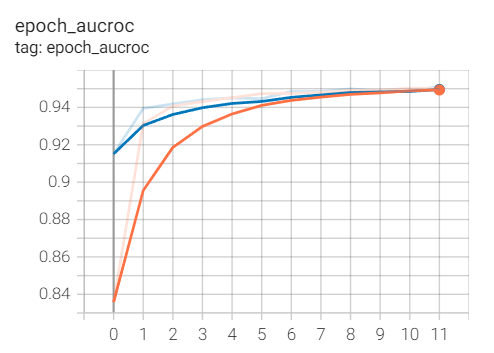

In [76]:
from IPython.display import Image
PATH = "D:/APPLIED AI/Assignments/Assignment 23 - NLP with transfer learning/result_images/"

Image(filename = PATH + "aucroc_vs_epoch.png", width=400, height=80)

In all the 3 images the orange line represents the training curve and blue line represents the validation curve

The AUC score increases with epochs

The maximum train and validation AUC score obtained are 0.9501and 0.9512 respectively

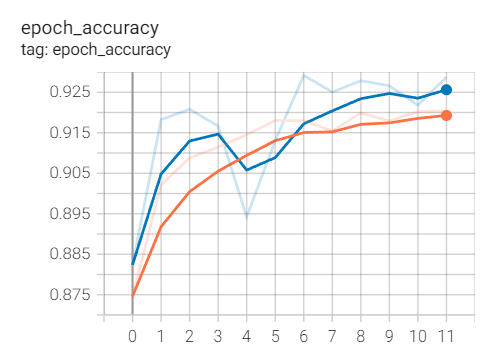

In [77]:
Image(filename = PATH + "acc_vs_epoch.png", width=400, height=80)

Accuracy increases with epochs

The maximum train and validation accuracy observed are 0.9204 and 0.9287 respectively

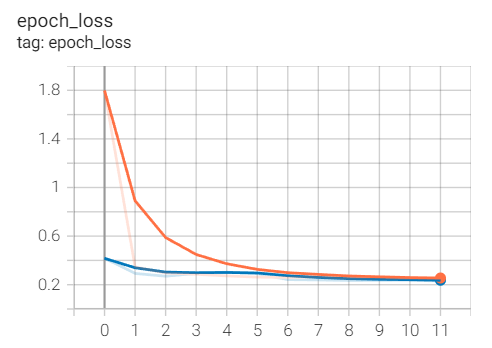

In [79]:
Image(filename = PATH + "loss_vs_epoch.png", width=400, height=80)

Loss decreases with each epoch

The minimum loss observed are : val_loss: 0.2304 and train_loss: 0.2492

In [74]:
%load_ext tensorboard

<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 
1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a> </pre>


In [141]:
#read the csv file

test_df= pd.read_csv('test.csv')
test_df.head(5)

,Text
0,Just opened Greenies Joint Care (individually ...
1,This product rocks :) My mom was very happy w/...
2,"The product was fine, but the cost of shipping..."
3,I love this soup. It's great as part of a meal...
4,Getting ready to order again. These are great ...


<Pre>1. You have to write a function that takes the test_df,trained model and the required parameters as input. 
2. Perform all the preproceesing steps inside the function.
- Remove all the html tags
- Now do tokenization [Part 3 as mentioned above]
- Create tokens,mask array and segment array
- Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
- Print the shape of output(X_test.shape).You should get (352,768)
3. Predit the output of X_test with the neural network model which we trained earlier.

4. Return the occurences of class labels from the function.
The output should be the count of datapoints classified as 1 or 0.

</pre>

In [119]:
def Test_data_embedding(input_data, model, tokenizer):
    
    input_data.dropna(subset = ["Text"], inplace=True)                                  ## remove datapoints with Nan values
    input_data['Text'] = input_data['Text'].str.replace(r'<[^<>]*>', '', regex=True)    ## remove HTML tags
    
    ### CREATING INPUTS FOR BERT ###    
    tokens_array,mask_array,segment_array = Bert_inputs(input_data,tokenizer)
    
    ### Embedding using BERT model
    X_test = model.predict([tokens_array,mask_array,segment_array])
    print('Shape of X_test after embedding using BERT model :',X_test.shape)
    
    return X_test

In [120]:
X_test = Test_data_embedding(test_df, bert_model, tokenizer)

Shape of X_test after embedding using BERT model : (352, 768)


In [122]:
### predicting class label from previously trained network ###

prediction = model.predict(X_test)
predicted_y = prediction.argmax(axis=-1)

In [149]:
scores = np.unique(predicted_y,return_counts=True)
print('The number of positively and negatively classified points are',scores[1][1], 'and',scores[1][0] ,'respectively')

The number of positively and negatively classified points are 314 and 38 respectively


In [138]:
test_df['predicted_y'] = predicted_y
test_df.head(15)

,Text,predicted_y
0,Just opened Greenies Joint Care (individually ...,0
1,This product rocks :) My mom was very happy w/...,1
2,"The product was fine, but the cost of shipping...",0
3,I love this soup. It's great as part of a meal...,1
4,Getting ready to order again. These are great ...,1
5,"These were delicious, but not wrapped as well ...",1
6,I will never again even CONSIDER a dog food wi...,0
7,If you need something to take with you to keep...,1
8,My husband puts this on everything. It is very...,1
9,This is a movie the whole family can watch tog...,1


# OBSERVATOINS

From the above dataframe, for each text review the corresponding class label/sentiment score is provided and from observing the above given 15 observations, we can say that the class labels have been predicted with significant accuracy.

The prediction was made using the previously trained neural network model 


In this assignmet,the BERT uncased model model was used as Vectorization strategy

The Steps used in predicting the class labels are :


- Initially the Preprocessing of the input dataset was performed ,followed by splitting to train and test dataset.

- Then the BERT uncased model was downloaded from tensorflow HUB and the model was createed.

- The BERT model needs 3 inputs : word_ids/tokens, input mask and segment_ids.The maximum size allowed for all these 3 inputs is 55. If the length of input was less than 55 padding was performed and if the length of input was greater than 55 truncation was performed

- The word_ids/tokens were created using the tokenizer module which has functions for converting words to tokens and for positional encoding. The mask input was created by filling 0s to the places that were padded(represented by 'PAD') and 1s to the other places. The segment_ids were made to all zeroes as here we are giving only one sentence at a time.

- Then Embedding was obtained by giving these 3 inputs to the BERT model. The output was of 768 dimension.

- Then a simple neural network was created with the embedding vector given as the input and it was trained for 12 epochs.

- The model gave an a test accuracy of 0.9287  and test AUC score of 0.9512.

- Then the test dataset 'test_df' was provided.

- Here again the above steps were performed. It was preprocessed, inputs for BERT model were created and embedding was obtained. Now this was given to the previously trained neural network model to predict the sentiment scores for the reviews.



